In [58]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVR

In [84]:
X_train = pd.read_csv('../data_students/labeled_data/X_train_combined.csv')
X_test = pd.read_csv('../data_students/labeled_data/X_test_combined.csv')
y_train = pd.read_csv('../data_students/labeled_data/y_train.csv', header=None).squeeze()
y_test = pd.read_csv('../data_students/labeled_data/y_test.csv', header=None).squeeze()

X_to_predict = pd.read_csv('../data_students/unlabeled_data/X_predict_combined.csv')

In [85]:
cholesterol_indexes = X_train[X_train['cholesterol'] < 5].index
X_train = X_train.drop(cholesterol_indexes).reset_index(drop=True)
y_train = y_train.drop(cholesterol_indexes).reset_index(drop=True)

label_encoders = LabelEncoder()
X_train['profession'] = label_encoders.fit_transform(X_train['profession'])
X_test['profession'] = label_encoders.transform(X_test['profession'])
X_to_predict['profession'] = label_encoders.transform(X_to_predict['profession'])

categorical_columns = X_train.select_dtypes(include=['object']).columns
satisfaction_order = ['Very low', 'Low', 'Moderate', 'High', 'Very high']
ordinal_encoders = OrdinalEncoder(categories=[satisfaction_order])
for column in categorical_columns:
    X_train[column] = ordinal_encoders.fit_transform(X_train[column].values.reshape(-1, 1))
    X_test[column] = ordinal_encoders.transform(X_test[column].values.reshape(-1, 1))
    X_to_predict[column] = ordinal_encoders.transform(X_to_predict[column].values.reshape(-1, 1))

scaler = StandardScaler()
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_to_predict[numerical_columns] = scaler.transform(X_to_predict[numerical_columns])

If we ever need to seperate the two:

In [86]:
tabular_features = ['age','blood pressure','calcium','cholesterol','hemoglobin','height','potassium','profession','sarsaparilla','smurfberry liquor','smurfin donuts','vitamin D','weight']
img_features = [col for col in X_train.columns if col not in tabular_features]

X_train_tabular = X_train[tabular_features].copy()
X_train_pixels = X_train[img_features].copy()

X_test_tabular = X_test[tabular_features].copy()
X_test_pixels = X_test[img_features].copy()

X_to_predict_tabular = X_to_predict[tabular_features].copy()
X_to_predict_pixels = X_to_predict[img_features].copy()

print(len(tabular_features))
print(len(img_features))

13
8192


### Features selection

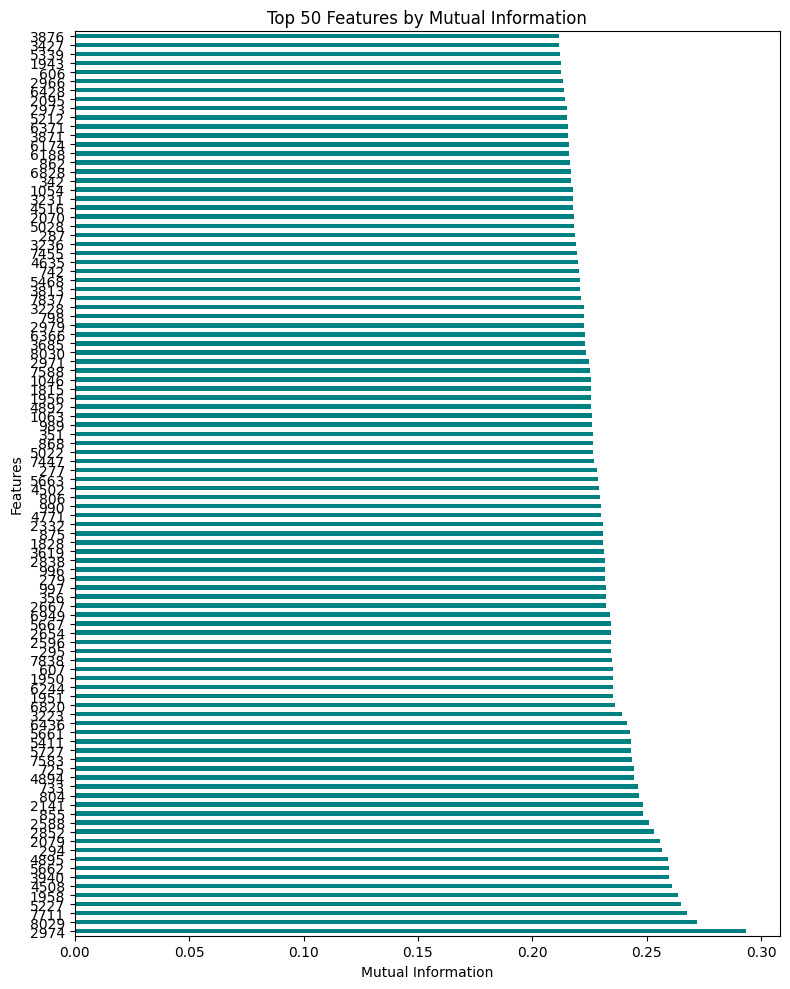

In [62]:
from matplotlib import pyplot as plt
from sklearn.feature_selection import mutual_info_regression, SelectKBest, SelectPercentile
import pandas as pd

importances = mutual_info_regression(X_train, y_train)

feat_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
feat_importances_top100 = feat_importances.iloc[:100]

plt.figure(figsize=(8, 10))
feat_importances_top100.plot(kind='barh', color='teal')
plt.title('Top 50 Features by Mutual Information')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
final_col = feat_importances[feat_importances > 0.01].index

def selectKBest(X, y, k):
    select_col = SelectKBest(mutual_info_regression, k=k)
    select_col.fit(X, y)
    return X[X.columns[select_col.get_support()]]

def selectPercentile(X, y, percentile):
    select_col = SelectPercentile(mutual_info_regression, percentile=percentile)
    select_col.fit(X, y)
    return X[X.columns[select_col.get_support()]]

In [63]:
def corr(features, predictions, n_features):
    predictions = predictions.squeeze()
    features_copy = features.copy()
    features_copy['target'] = predictions
    corr = features_copy.corr(method='pearson')['target'].drop('target')
    abs_corr = corr.abs().sort_values(ascending=False)
    return abs_corr.iloc[:n_features].index.tolist()

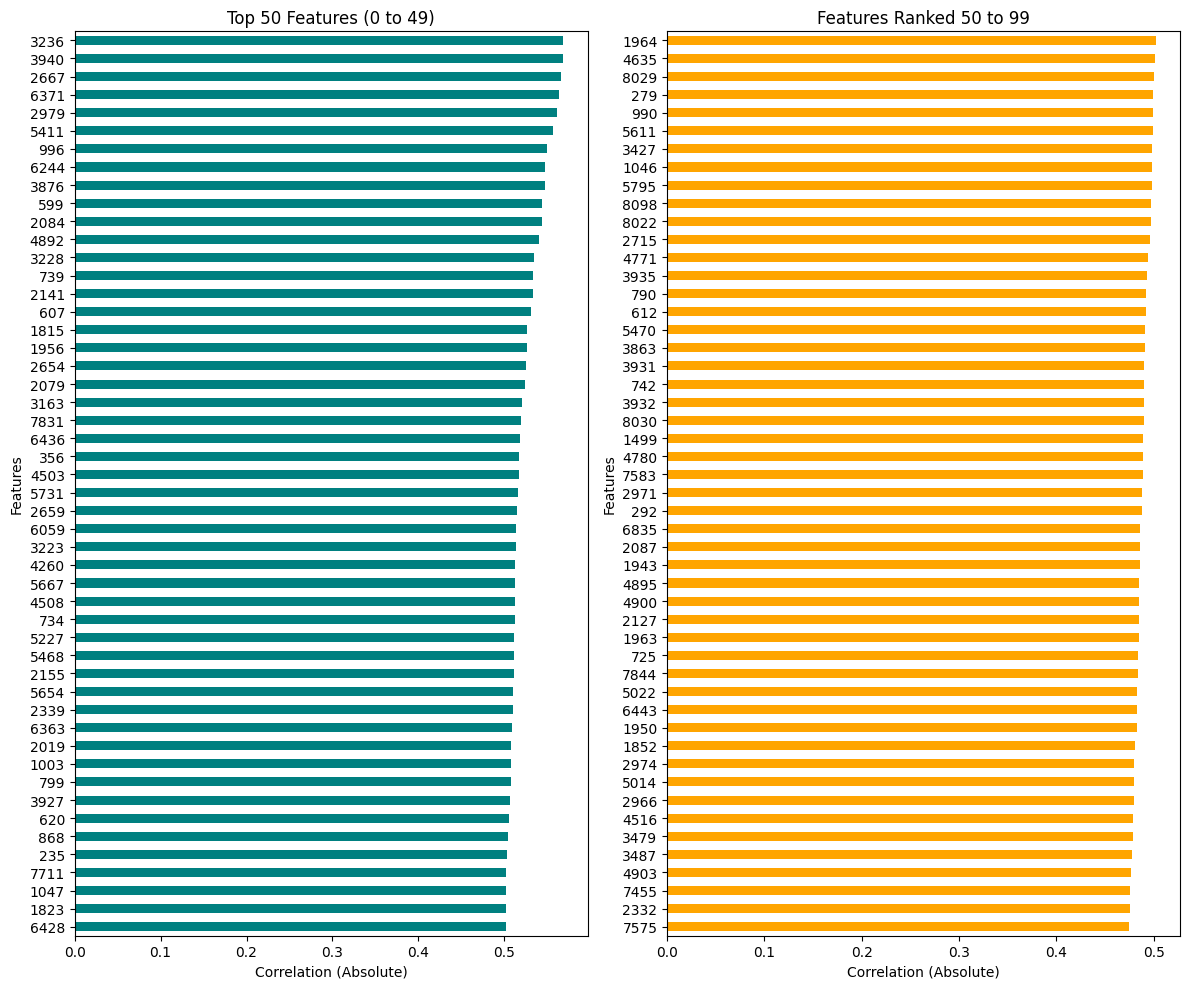

In [64]:
corr_values = corr(X_train, y_train, 100)
_, axes = plt.subplots(1, 2, figsize=(12, 10))
top_50_features = pd.Series(
    [X_train[c].corr(y_train) for c in corr_values[:50]],
    index=corr_values[:50]
)
next_50_features = pd.Series(
    [X_train[c].corr(y_train) for c in corr_values[50:100]],
    index=corr_values[50:100]
)
top_50_features.abs().sort_values(ascending=True).plot(kind='barh', ax=axes[0], color='teal')
axes[0].set_title('Top 50 Features (0 to 49)')
axes[0].set_xlabel('Correlation (Absolute)')
axes[0].set_ylabel('Features')
next_50_features.abs().sort_values(ascending=True).plot(kind='barh', ax=axes[1], color='orange')
axes[1].set_title('Features Ranked 50 to 99')
axes[1].set_xlabel('Correlation (Absolute)')
axes[1].set_ylabel('Features')
plt.tight_layout()
plt.show()

In [87]:
top_tabular_features = corr(X_train_tabular, y_train, 9)
corr_pixels = corr(X_train_pixels, y_train, 40)
# X_train_selection = corr(X_train, y_train, 256)

In [88]:
model = SVR()

param_grid = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    # 'C': [0.01, 0.05, 0.1, 0.5, 1],
    'C': [0.18, 0.9, 0.2],
    # 'epsilon': [0.01, 0.05, 0.1, 0.5, 1],
    'epsilon': [0.0115, 0.012, 0.0125],
    'p': [19,20,21,22,23]
    # 'p': [2,4,8,16,32,64,128, 256]
}

results = []
for p in param_grid['p']:
    top_pixel_features = corr_pixels[:p]
    X_train_selected = np.hstack([X_train_tabular[top_tabular_features], X_train_pixels[top_pixel_features]])
    # X_train_selected = X_train[X_train_selection[:p]]
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)
    
    svr_param_grid = {
        'kernel': param_grid['kernel'],
        'C': param_grid['C'],
        'epsilon': param_grid['epsilon']
    }
    grid_search = GridSearchCV(model, svr_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_split, y_train_split)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_val_pred = best_model.predict(X_val)
    rmse_val = root_mean_squared_error(y_val, y_val_pred)
    std_val = np.std(y_val - y_val_pred)
    
    results.append({
        'k': best_params['kernel'],
        'p': p,
        'C': best_params['C'],
        'epsilon': best_params['epsilon'],
        'validation_rmse': rmse_val,
        'validation_std': std_val
    })

results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['validation_rmse'].idxmin()]
best_k = best_result['k']
best_p = best_result['p']
best_C = best_result['C']
best_epsilon = best_result['epsilon']
print(f"\nRMSE= {best_result['validation_rmse']:.4f}, STD= {best_result['validation_std']:.4f}")
print(f"Best Parameters: k={best_k}, p={best_p}, C={best_C}, epsilon={best_epsilon}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits

RMSE= 0.0462, STD= 0.0461
Best Parameters: k=rbf, p=19, C=0.2, epsilon=0.0125


RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
RMSE:  0.04367644416204759
Mean RMSE:  0.04367644416204759


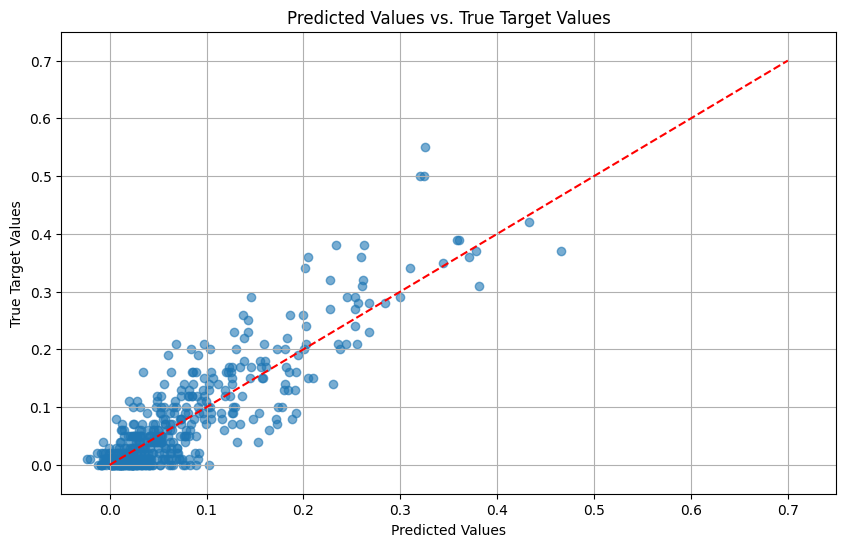

RMSE: 0.0437


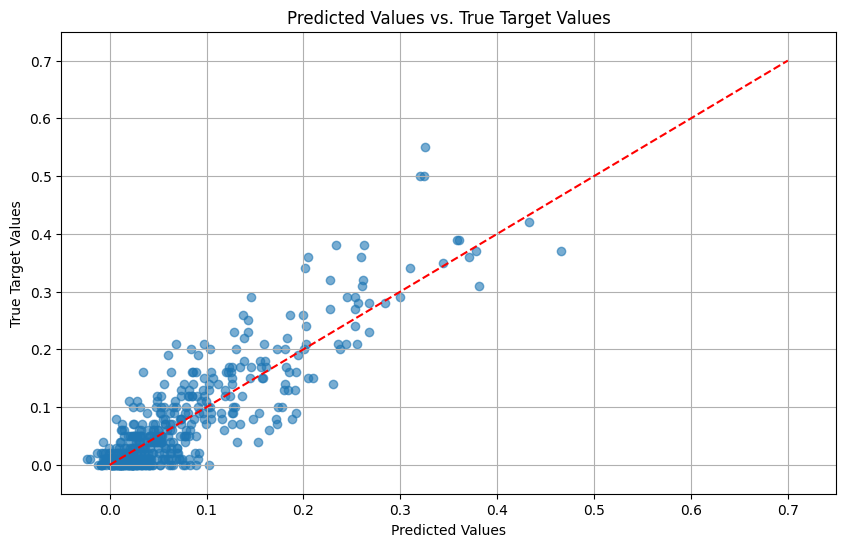

Done!


In [95]:
# top_pixel_features = corr_pixels[:int(best_p)]
best_k = 'rbf'
best_C = 0.2
best_epsilon = 0.0115
top_pixel_features = corr_pixels[:21]
top_tabular_features = corr(X_train_tabular, y_train, 9)

X_train_final = np.hstack([X_train_tabular[top_tabular_features], X_train_pixels[top_pixel_features]])
X_test_final = np.hstack([X_test_tabular[top_tabular_features], X_test_pixels[top_pixel_features]])

rmse = []
best_rmse = float('inf')
best_y_pred = None
for _ in range(1, 11):
    
    best_model = SVR(kernel=best_k, C=best_C, epsilon=best_epsilon)
    best_model.fit(X_train_final, y_train)
    y_pred = best_model.predict(X_test_final)
    print("RMSE: ", root_mean_squared_error(y_test, y_pred))
    rmse.append(root_mean_squared_error(y_test, y_pred))
    
    if rmse[-1] < best_rmse:
        best_rmse = rmse[-1]
        best_y_pred = y_pred
                
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
print("Mean RMSE: ", mean_rmse)

plt.figure(figsize=(10, 6))
plt.scatter(best_y_pred, y_test, alpha=0.6)
plt.plot([0, 0.7], [0, 0.7], 'r--')

plt.xlabel('Predicted Values')
plt.ylabel('True Target Values')
plt.title('Predicted Values vs. True Target Values')
plt.grid(True)

plt.xlim(-0.05, 0.75)
plt.ylim(-0.05, 0.75)
plt.show()

final_model = SVR(kernel=best_k, C=best_C, epsilon=best_epsilon)
final_model.fit(X_train_final, y_train)

y_test_pred = final_model.predict(X_test_final)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

print(f"RMSE: {test_rmse:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, y_test, alpha=0.6)
plt.plot([0, 0.7], [0, 0.7], 'r--')

plt.xlabel('Predicted Values')
plt.ylabel('True Target Values')
plt.title('Predicted Values vs. True Target Values')
plt.grid(True)

plt.xlim(-0.05, 0.75)
plt.ylim(-0.05, 0.75)
plt.show()

X_to_predict_final = np.hstack([X_to_predict_tabular[top_tabular_features], X_to_predict_pixels[top_pixel_features]])
y_to_predict = final_model.predict(X_to_predict_final)

output = pd.DataFrame(y_to_predict)
output.to_csv('y_pred.csv', index=False, header=False)

print("Done!")



In [71]:
model = MLPRegressor(max_iter=1000, random_state=42)

param_grid = {
    'hidden_layer_sizes': [(100,150,100),(150,150,150), (150,100,50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'alpha': [0.001, 0.01, 0.1],
    # 'alpha': [0.11, 0.15, 0.2],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
    # 'learning_rate': ['constant']
}

P = [19,20,21,22,23]
# P = [21]
results = []
for p in P:
    
    top_pixel_features = corr_pixels[:p]
    X_train_selected = np.hstack([X_train_tabular[top_tabular_features], X_train_pixels[top_pixel_features]])
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=42)

    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_split, y_train_split)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    y_val_pred = best_model.predict(X_val)
    rmse_val = root_mean_squared_error(y_val, y_val_pred)
    std_val = np.std(y_val - y_val_pred)
    
    results.append({
        'p': p,
        'hidden_layer_sizes': best_params['hidden_layer_sizes'],
        'activation': best_params['activation'],
        'alpha': best_params['alpha'],
        'learning_rate': best_params['learning_rate'],
        'validation_rmse': rmse_val,
        'validation_std': std_val
    })

results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['validation_rmse'].idxmin()]
best_p - best_result['p']
best_hidden_layer_sizes = best_result['hidden_layer_sizes']
best_activation = best_result['activation']
best_alpha = best_result['alpha']
best_learning_rate = best_result['learning_rate']
print(f"\nRMSE= {best_result['validation_rmse']:.4f}, STD= {best_result['validation_std']:.4f}")
print(f"Best Parameters: p={best_p}, hidden_layer_sizes={best_hidden_layer_sizes}, activation={best_activation}, "
      f"alpha={best_alpha}, learning_rate={best_learning_rate}.")

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Fitting 10 folds for each of 108 candidates, totalling 1080 fits


KeyboardInterrupt: 

RMSE:  0.045393505261473226


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE:  0.04441978785825507
RMSE:  0.04612882975152132
RMSE:  0.04541124392212842
RMSE:  0.04512773952417159
RMSE:  0.04782343398175707
RMSE:  0.044631619279643


/Users/baptiste/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE:  0.04559449744115326
RMSE:  0.04553438430897521
RMSE:  0.045312301631849065
Mean RMSE:  0.04553773429609272


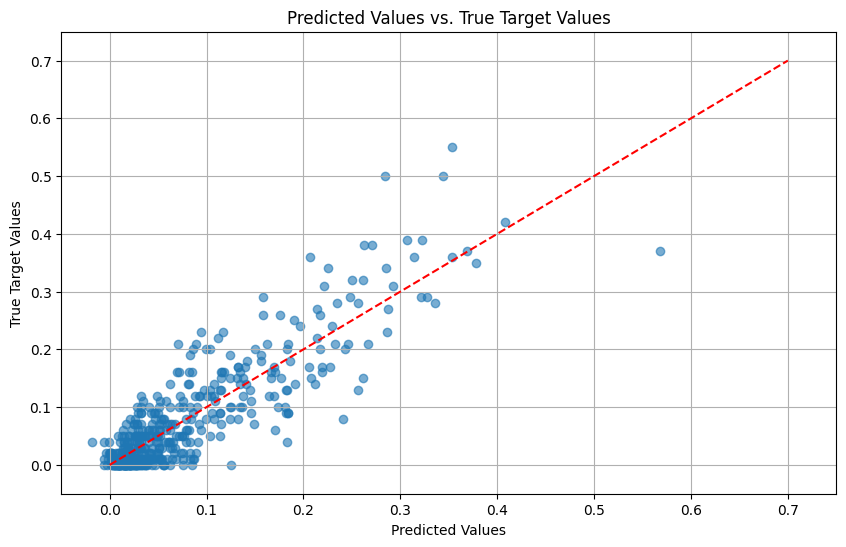

In [82]:
best_p = 19
best_activation = 'relu'
best_alpha = 0.1
best_hidden_layer_sizes = (150, 150, 150)
best_learning_rate = 'constant'
top_pixel_features = corr_pixels[:int(best_p)]
X_train_final = np.hstack([X_train_tabular[top_tabular_features], X_train_pixels[top_pixel_features]])
X_test_final = np.hstack([X_test_tabular[top_tabular_features], X_test_pixels[top_pixel_features]])

rmse = []
best_rmse = float('inf')
best_y_pred = None
for _ in range(1, 11):
    
    best_model = MLPRegressor(activation=best_activation, alpha=best_alpha, hidden_layer_sizes=best_hidden_layer_sizes, learning_rate=best_learning_rate)
    best_model.fit(X_train_final, y_train)
    y_pred = best_model.predict(X_test_final)
    print("RMSE: ", root_mean_squared_error(y_test, y_pred))
    rmse.append(root_mean_squared_error(y_test, y_pred))
    
    if rmse[-1] < best_rmse:
        best_rmse = rmse[-1]
        best_y_pred = y_pred
                
mean_rmse = np.mean(rmse)
std_rmse = np.std(rmse)
print("Mean RMSE: ", mean_rmse)

plt.figure(figsize=(10, 6))
plt.scatter(best_y_pred, y_test, alpha=0.6)
plt.plot([0, 0.7], [0, 0.7], 'r--')

plt.xlabel('Predicted Values')
plt.ylabel('True Target Values')
plt.title('Predicted Values vs. True Target Values')
plt.grid(True)

plt.xlim(-0.05, 0.75)
plt.ylim(-0.05, 0.75)
plt.show()
